In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import timm
import detectors

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy
from tqdm import tqdm
from ffcv.writer import DatasetWriter
from ffcv.fields import BytesField, IntField, RGBImageField

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset
from data_utils import texture_vs_shape_transformations as ts
from utils.metrics import topk_acc, real_acc, AverageMeter

import save_jpg_dataset 

c:\Users\Leonidas\anaconda3\envs\ffcv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# define important parameters

dataset         = 'cifar10'               # One of cifar10, cifar100, stl10, imagenet or imagenet21
num_classes     = CLASS_DICT[dataset]
data_path       = 'C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\beton'
eval_batch_size = 32
data_resolution = 32 
checkpoint      = None
dataset_type    = 'grayscale' # occluded, shuffled, grayscale, edged, stylized, random_blacken



model_type      = 'mlp'                   
checkpoint      = 'in21k_cifar10'       
architecture    = 'B_12-Wi_1024'        
crop_resolution = 64
model_path      = 'C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\checkpoints'            

#model_type      = 'cnn'               
#architecture    = 'resnet18_' + dataset                      
#crop_resolution = 32

#model_type      = 'vit'                  
#architecture    = 'vit_small_patch16_224_' + dataset + '_v7.pth'        
#crop_resolution = 224 
#model_path      = 'C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps'

In [4]:
def get_models_full(model_type, 
                    architecture, 
                    resolution  = crop_resolution, 
                    num_classes = CLASS_DICT[dataset], 
                    checkpoint  = checkpoint, 
                    model_path   = model_path):
    if model_type == 'mlp':
        model = get_model(architecture=architecture, resolution = resolution, 
                          num_classes=num_classes,checkpoint= checkpoint)
    elif model_type == 'cnn':
        model = timm.create_model(architecture, pretrained=True)
    elif model_type == 'vit':
        model = torch.load(os.path.join(model_path, architecture))
    return model

In [5]:
# load the models
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_models_full(model_type, architecture)
with torch.no_grad():
    model.eval()
    

Weights already downloaded
Load_state output <All keys matched successfully>


In [7]:
# Get the test loader (for all dataset_type´s except for stylized )
loader = ts.get_Shapeloader(
        dataset   = dataset,
        bs        = eval_batch_size,
        mode      = "test",
        augment   = "False",
        dev       = device,
        mixup     = 0.0,
        data_path = data_path,
        data_resolution = data_resolution,
        crop_resolution = crop_resolution,
        dataset_type    = dataset_type
        )

Loading C:\Users\Leonidas\OneDrive\Desktop\zooming_in_on_mlps\beton\cifar10\val_32.beton


In [ ]:
# Get the Stylized Dataset test loader

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),  
    transforms.ToTensor(),])

stylized_dataset = ts.StylizedDataset('C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\stylized_datasets\\cifar10_None', transform=transform)

loader = ts.DataLoader(stylized_dataset, batch_size=eval_batch_size, shuffle=True)

In [ ]:
# image viewing
import matplotlib.pyplot as plt

with torch.no_grad():
    dataiter    = iter(loader)
    ims, labels = next(dataiter)
    img_to_show = ims[225]
    print(ims.shape, labels.shape)
    
    if not isinstance(img_to_show, np.ndarray):
        img_to_show = img_to_show.numpy()
    
    print(img_to_show.shape)
    # for shuffled images need to add .astype(np.uint8)
    plt.imshow(img_to_show.T)

In [8]:
# Defines a test function that evaluates the test accuracy of the loaded model/transformation 
# for every class of cifar10 .

@torch.no_grad()    
def test_class_n(model, loader,n):
    model.eval()
    class_n_acc = AverageMeter()
    
    

    for ims, targs in tqdm(loader, desc="Evaluation"):
        ims = torch.reshape(ims, (ims.shape[0], -1)) #comment for vit and cnn
        preds = model(ims)
        
        targs_new_list = []
        preds_new_list = []
        
        for i in range(len(targs)) :
            if targs[i] == n:
                targs_new_list.append(targs[i])
                preds_new_list.append(preds[i])
                
        if not targs_new_list:
            continue 
                
        targs_new = torch.stack(targs_new_list)
        preds_new = torch.stack(preds_new_list)        
        
        acc = real_acc(preds_new, targs_new, k=5, avg=True)
        class_n_acc.update(acc, ims.shape[0]) 
        
           
    return (
        class_n_acc.get_avg(percentage=True),
        
    )

In [9]:
tuple_1 = test_class_n(model, loader, n=0)
tuple_2 = test_class_n(model, loader, n=1)
tuple_3 = test_class_n(model, loader, n=2)
tuple_4 = test_class_n(model, loader, n=3)
tuple_5 = test_class_n(model, loader, n=4)
tuple_6 = test_class_n(model, loader, n=5)
tuple_7 = test_class_n(model, loader, n=6)
tuple_8 = test_class_n(model, loader, n=7)
tuple_9 = test_class_n(model, loader, n=8)
tuple_10 = test_class_n(model, loader, n=9)


test_class_1_acc = np.array(tuple_1[0].item()) 
test_class_2_acc = np.array(tuple_2[0].item())
test_class_3_acc = np.array(tuple_3[0].item())
test_class_4_acc = np.array(tuple_4[0].item())
test_class_5_acc = np.array(tuple_5[0].item())
test_class_6_acc = np.array(tuple_6[0].item()) 
test_class_7_acc = np.array(tuple_7[0].item())
test_class_8_acc = np.array(tuple_8[0].item())
test_class_9_acc = np.array(tuple_9[0].item())
test_class_10_acc = np.array(tuple_10[0].item())

test_all_classes_acc = np.array([test_class_1_acc, test_class_2_acc, test_class_3_acc, test_class_4_acc, test_class_5_acc, test_class_6_acc, test_class_7_acc, test_class_8_acc, test_class_9_acc, test_class_10_acc])

print(test_all_classes_acc)

Evaluation: 100%|██████████| 313/313 [00:35<00:00,  8.71it/s]

[92.54045105 88.97936249 71.49646759 77.97342682 86.50072479 59.69168854
 85.85034943 89.44352722 90.21063232 89.87423706]


In [10]:
import numpy as np

acc_B_6_Wi_1024_grayscale = np.array( [ 91.05131531, 86.94757843, 74.10126495, 85.72374725, 76.20401001, 52.99678802,
 84.8077774,  88.26673126, 89.36522675, 89.55335999 ] )

acc_B_12_Wi_512_grayscale = np.array( [88.37667084, 87.39603424, 67.10150909, 74.13900757, 85.02353668, 60.31974411,
 84.15388489, 82.60232544, 87.83692169, 86.37935638] )

acc_B_12_Wi_1024_grayscale = np.array( [92.89955902, 89.19692993, 72.6411972,  78.34481049, 87.28790283, 58.75828171,
 86.50020599, 89.56361389, 90.22936249, 89.30231476] )

acc_Vit_grayscale = np.array([86.49180603, 71.91024017, 55.45617676, 68.89159393, 28.20960617, 49.49403,
 78.20308685, 68.93723297, 73.01689148, 78.77670288])

acc_CNN_grayscale = np.array([90.61014557, 93.86965942, 80.90284729, 90.144104,   82.69236755, 81.28423309,
 88.97644806, 89.74946594, 94.26036072, 93.65608978])

acc_B_6_Wi_1024_occluded = np.array([53.08001709, 18.08327293, 32.15969467, 63.78274918, 61.78154373, 14.79931068,
 54.52146149, 59.60133743, 39.61979675, 90.95539856])

acc_B_12_Wi_512_occluded = np.array([46.39562607, 35.46609497, 35.95750809, 65.17063904, 72.50765228, 22.90449524,
 68.59016418, 51.20819473, 40.42970276, 80.07617188])

acc_B_12_Wi_1024_occluded = np.array([42.22877884, 28.89429092, 33.46313477, 59.05407333, 65.33518219, 26.29924393,
 63.94490051, 48.05069351, 44.27942657, 92.26887512])

acc_Vit_occluded = np.array([65.96934509, 43.13392639, 36.34418869, 30.6887188,  66.62083435, 72.92346954,
 75.19059753, 64.50043488, 68.42920685, 82.44572449])

acc_CNN_occluded = np.array([55.28726959, 37.82196426, 27.41372108, 37.90256119, 19.68580627, 21.96700096,
  9.89237499, 25.03257751, 54.73659515, 78.98101044])

acc_B_6_Wi_1024_shuffled = np.array( [18.79232788,  4.1056633,  20.53235817, 61.96291351, 10.29120159,  2.43322206,
 31.32199669,  3.37344646,  1.93550956, 36.54999924] )

acc_B_12_Wi_512_shuffled = np.array( [21.1451664,   8.72416115, 21.20679283, 38.36938095, 25.66277313,  6.98691797,
 60.04463196,  4.59525204,  1.12941515, 25.96764755] )

acc_B_12_Wi_1024_shuffled = np.array( [21.464468,    2.16050029, 22.4867115,  27.42060852, 15.35399818,  8.52153301,
 45.00590134,  1.51962268,  2.08689713, 65.87516785] )

acc_Vit_shuffled = np.array([15.12406921, 36.91381454,  3.72144604,  4.0792861,  21.68631935,  0.17010893,
 48.19360352,  6.90230942, 17.11802101, 73.72682953])

acc_CNN_shuffled = np.array([49.53892136,  6.10336494, 16.64393044, 31.72009468, 34.00931168,  7.60824776,
 14.88562965, 17.25509071, 43.15248489, 87.3731308 ])

acc_B_6_Wi_1024_edged = np.array( [26.22754097,  0, 52.56335449, 45.36129379,  3.19338536,  2.17657304,
 10.36157703,  4.94099617,  6.88224554,  0.88249433] )

acc_B_12_Wi_512_edged = np.array( [25.30340195,  0, 30.68169594,  1.56946588, 63.4537735,   2.66037869,
 71.53362274, 14.8876543,   9.68804264,  1.81101382] )

acc_B_12_Wi_1024_edged = np.array( [20.89010239,  1.0620209,  25.51878548, 27.75455284,  2.30547452, 12.31927967,
 67.82021332, 19.16462898,  9.83451843,  7.23236465] )

acc_Vit_edged = np.array([34.630867,    2.20848584, 79.14897156, 10.69510841, 10.39525127,  4.52732897,
 12.3185606,   8.23303413, 59.24209213, 10.6900959 ])

acc_CNN_edged = np.array([51.38577652, 37.54698944, 27.07089043, 87.02065277, 34.97031403, 32.18006897,
 25.10679817, 46.36006165, 46.44708252, 22.46714211])

acc_B_12_Wi_1024_stylized = np.array([39.90654755, 15.93119526, 46.84309387, 72.53974915, 57.97940445, 16.54092789,
 53.29493713, 52.82378387, 63.10653305, 62.01987457])

acc_CNN_stylized = np.array([ 9.97588062,  0.22400002,  2.05261755, 77.90389252,  2.09117484, 41.80592346,
  5.49640369,  6.81733847, 38.77479553,  0.87649888])

acc_Vit_stylized = np.array([39.32353973,  9.88996124, 20.30921936, 23.01281929, 72.53091431, 33.56742096,
 27.86868668, 25.85408211, 77.06575012, 34.18893814])


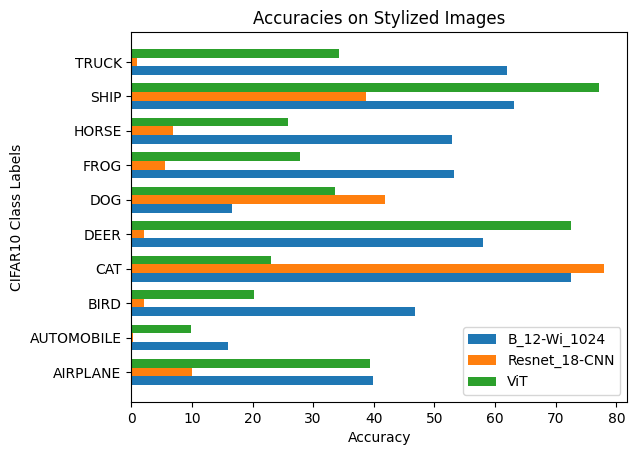

In [11]:
#plots the class accuracies for the 3 models tested on modified images of cifar10 

import numpy as np
import matplotlib.pyplot as plt


acc_model1 = acc_B_12_Wi_1024_stylized
acc_model2 = acc_CNN_stylized
acc_model3 = acc_Vit_stylized
class_labels = ['AIRPLANE', 'AUTOMOBILE', 'BIRD', 'CAT', 'DEER', 'DOG', 'FROG', 'HORSE', 'SHIP', 'TRUCK']

bar_width = 0.25
index = np.arange(len(class_labels))

plt.barh(index, acc_model1, height=bar_width, label='B_12-Wi_1024')
plt.barh(index + bar_width, acc_model2, height=bar_width, label='Resnet_18-CNN')
plt.barh(index + 2 * bar_width, acc_model3, height=bar_width, label='ViT')

plt.yticks(index + bar_width, class_labels)
plt.xlabel('Accuracy')
plt.ylabel('CIFAR10 Class Labels')
plt.title('Accuracies on Stylized Images')
plt.legend()

plt.show()
 

